### Setup

In [1]:
%%capture
%load_ext sql
%sql sqlite:///jobs.db

# Subqueries
### Writing more complex queries

The other missions in this course so far have prepared us to answer one question at a time. Often, however, we want to answer questions that involves multiple queries. For example, consider the following:

**Which rows are above the average for the ShareWomen column?**

To determine which majors are above average for the ShareWomen column, we need to do the following:

- Determine the average value for the ShareWomen column.
- Select and filter the rows that are greater than the average value.

Simply trying the query below doesn't work.

```
SELECT *
  FROM recent_grads
 WHERE ShareWomen > AVG(ShareWomen);
```

We get an error.


We can, however, first find AVG(ShareWomen), copy the value manually and replace it in the query above.

```
SELECT AVG(ShareWomen)
  FROM recent_grads;

---> 0.5225
```

In [3]:
%%sql

SELECT Major, ShareWomen
FROM recent_grads
WHERE ShareWomen > 0.5225502
LIMIT 5

 * sqlite:///jobs.db
Done.


Major,ShareWomen
ACTUARIAL SCIENCE,0.535714286
COMPUTER SCIENCE,0.578766338
ENVIRONMENTAL ENGINEERING,0.558548009
NURSING,0.896018988
INDUSTRIAL PRODUCTION TECHNOLOGIES,0.75047259


## Subqueries

Our method in the previous screen lacks flexibility and requires extra work. Fortunately, SQL allows us to answer questions with a single query.

How do we make the computed average value, 0.5225502029537575, dynamic? We can do this by using **subqueries**. A subquery is a query nested within another query. Here's a template for a SQL statement where the subquery resides in the WHERE clause:

```
SELECT Major, ShareWomen FROM recent_grads
WHERE ShareWomen > (subquery that returns the average value for ShareWomen)
```

The subquery runs first and returns the average value for the ShareWomen column (which happens to be 0.5225502029537575). Based on the result of the subquery, SQL will replace the subquery with this value dynamically.

SQL will ignore the column name (AVG(ShareWomen)) and use the actual row value. Here's a diagram that clarifies the flow:


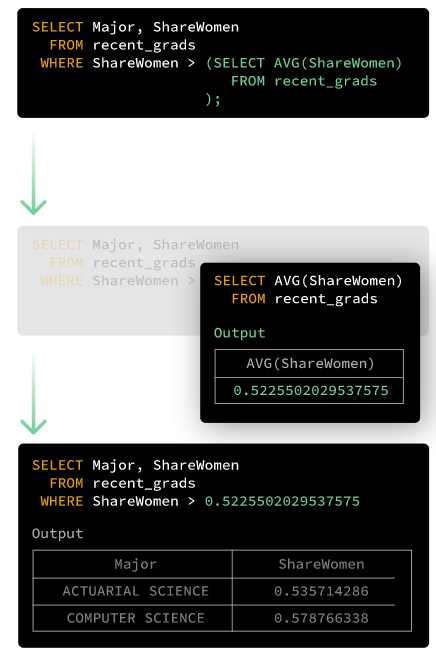

The query that replaces the placeholder subquery needs to be a full query (like the ones we've seen so far).

For this particular example, the inner query should only return a table with a single row and a column because of how it fits within the outer query (... WHERE > ?). **If you try to return a table with multiple columns, you will get an error.**

Lastly, a subquery must always be inside parentheses `()`. We get an error if we don't include them in the query above.

*Write a query that does the following:*
- *Displays, in order, the columns Major and Unemployment_rate.*
- *Displays all rows with an unemployment rate below average.*

In [5]:
%%sql

SELECT Major, Unemployment_rate
FROM recent_grads
WHERE Unemployment_rate < (SELECT AVG(Unemployment_rate)
                           FROM recent_grads)
LIMIT 5;

 * sqlite:///jobs.db
Done.


Major,Unemployment_rate
PETROLEUM ENGINEERING,0.018380527
METALLURGICAL ENGINEERING,0.024096386
NAVAL ARCHITECTURE AND MARINE ENGINEERING,0.050125313
CHEMICAL ENGINEERING,0.061097712
ASTRONOMY AND ASTROPHYSICS,0.021167415


## Subquery in SELECT

On the previous screen, we wrote SQL statements that used a subquery to express dynamic filter criteria in the WHERE clause. Specifically, we looked for rows that were above or below the average value in a specific column.

What if we wanted to understand the proportion of majors that are above the average for a given column? We'd need to divide the number of rows that met the filter criteria by the total number of rows in the table.

Let's focus on the query from the previous screen:

```
SELECT Major, ShareWomen
  FROM recent_grads
 WHERE ShareWomen > (SELECT AVG(ShareWomen)
                       FROM recent_grads
                    );
```

Using the COUNT aggregate function, we can return the number of rows in the results set:

In [6]:
%%sql 
SELECT COUNT(*)
  FROM recent_grads
 WHERE ShareWomen > (SELECT AVG(ShareWomen)
                     FROM recent_grads
                    );

 * sqlite:///jobs.db
Done.


COUNT(*)
91


To return the proportion, we need to **divide this value by the total number of rows in recent_grads**. We can count the number of rows in the table, save the result, and then divide by it. The challenge, however, is to do this dynamically!

To calculate the number of total rows in recent_grads and use it in another SQL statement, we can use a subquery in the SELECT clause:

In [7]:
%%sql 

SELECT COUNT(*),
       (SELECT COUNT(*)
          FROM recent_grads
       )
  FROM recent_grads
 WHERE ShareWomen > (SELECT AVG(ShareWomen)
                       FROM recent_grads
                    );

 * sqlite:///jobs.db
Done.


COUNT(*),(SELECT COUNT(*) FROM recent_grads )
91,173


*Now, extend the SQL statement to compute the actual proportion.*

*Write a SQL statement that computes the proportion (as a float value) of rows that contain above-average values for ShareWomen.*

*The results should only return the proportion, aliased as proportion_abv_avg*

In [8]:
%%sql

SELECT CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM recent_grads) AS proportion_abv_avg
    FROM recent_grads
    WHERE ShareWomen > (SELECT AVG(ShareWomen)
                            FROM recent_grads);

 * sqlite:///jobs.db
Done.


proportion_abv_avg
0.5260115606936416


## The IN Operator

We've been using operators like < and >. In the SQLite documentation, we see all of the following operators.

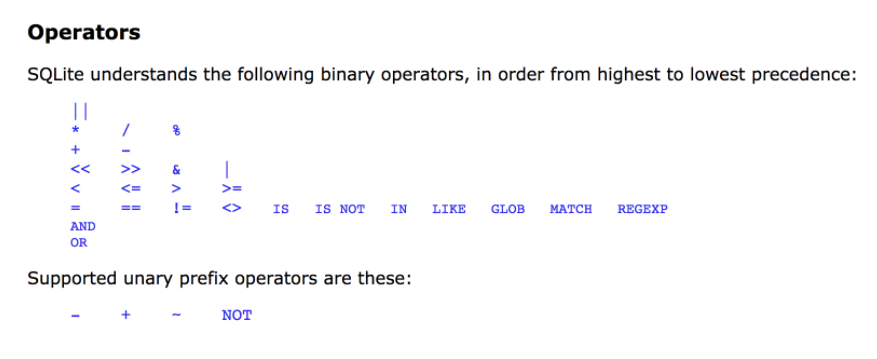

Using the IN operator, we can specify a list of values that we want to match in the WHERE clause. The following query returns the rows where Major_category equals either Business or Engineering:

In [9]:
%%sql

SELECT Major, Major_category
  FROM recent_grads
 WHERE Major_category IN ('Business', 'Engineering')
 LIMIT 7;

 * sqlite:///jobs.db
Done.


Major,Major_category
PETROLEUM ENGINEERING,Engineering
MINING AND MINERAL ENGINEERING,Engineering
METALLURGICAL ENGINEERING,Engineering
NAVAL ARCHITECTURE AND MARINE ENGINEERING,Engineering
CHEMICAL ENGINEERING,Engineering
NUCLEAR ENGINEERING,Engineering
ACTUARIAL SCIENCE,Business


Let's practice using IN.

*Write a query that displays the following:*

- In order, Major_category and Major
- All rows in any of the following categories:
    - Business
    - Humanities & Liberal Arts
    - Education

In [13]:
%%sql

SELECT Major_category, 
       Major
    FROM recent_grads
    WHERE Major_category IN ('Business', 'Humanities & Liberal Arts', 'Education')
    LIMIT 11

 * sqlite:///jobs.db
Done.


Major_category,Major
Business,ACTUARIAL SCIENCE
Business,MANAGEMENT INFORMATION SYSTEMS AND STATISTICS
Business,OPERATIONS LOGISTICS AND E-COMMERCE
Business,FINANCE
Business,BUSINESS ECONOMICS
Business,ACCOUNTING
Education,SCHOOL STUDENT COUNSELING
Business,GENERAL BUSINESS
Business,INTERNATIONAL BUSINESS
Business,MISCELLANEOUS BUSINESS & MEDICAL ADMINISTRATION


## Returning multiple results in subqueries

In the previous exercise, we displayed the majors in the categories Business, Humanities & Liberal Arts, and Education.

These are the top three categories with respect to the total number of graduates, as we can see in the query below.

In [15]:
%%sql

SELECT Major_category, SUM(TOTAL)
  FROM recent_grads
 GROUP BY Major_category
 ORDER BY SUM(TOTAL) DESC
 LIMIT 5;

 * sqlite:///jobs.db
Done.


Major_category,SUM(TOTAL)
Business,1302376
Humanities & Liberal Arts,713468
Education,559129
Engineering,537583
Social Science,529966


If we wanted to find the same list of majors as we saw in the previous screen, dynamically (i.e. without first determining the most popular categories and then hard-coding the values into the query), subqueries can help.

Instead of returning just one value, we can make the query return a list of values (disguised as a single column).

In the following exercise, you will display the same results as we saw in the previous screen, only this time you won't manually indicate the categories.

You can use the following code in this screen's exercise.

```
SELECT Major_category, Major
  FROM recent_grads
 WHERE Major_category IN (SUBQUERY_GOES_HERE);
```

*In the code displayed above, replace SUBQUERY_GOES_HERE to create a query that displays the Major and Major_category columns, for the rows where Major_category is one of the three highest group level sums for the Total column.*

In [17]:
%%sql

SELECT Major_category, Major
FROM recent_grads
WHERE Major_category IN (SELECT Major_category
                            FROM recent_grads
                            GROUP BY Major_category
                            ORDER BY SUM(Total) DESC
                            LIMIT 3
                        );

 * sqlite:///jobs.db
Done.


Major_category,Major
Business,ACTUARIAL SCIENCE
Business,MANAGEMENT INFORMATION SYSTEMS AND STATISTICS
Business,OPERATIONS LOGISTICS AND E-COMMERCE
Business,FINANCE
Business,BUSINESS ECONOMICS
Business,ACCOUNTING
Education,SCHOOL STUDENT COUNSELING
Business,GENERAL BUSINESS
Business,INTERNATIONAL BUSINESS
Business,MISCELLANEOUS BUSINESS & MEDICAL ADMINISTRATION


## Building complex subqueries

On the previous few screens, we nested subqueries in the WHERE and the SELECT clauses that underwent evaluation before the outer query.

We can actually **nest subqueries within subqueries many times**, but this complicates our SQL code and makes it harder to debug. In the next course, we'll explore **other techniques for composing SQL statements that simplfify nested logic.**

When you need to write a SQL statement that will end up using many subqueries, it can be overwhelming to know how to start.

In general, **you want to start with the inner queries first and work your way out**. For example, let's consider the *ratio of the Sample_size column in relation to the Total column*. You can read the dataset documentation if you need a reminder of what these columns represent.

Specifically, let's consider the following:

- Computing this ratio for every major.
- Understanding which majors are above the average for this ratio.
- Understanding how many majors are above the average for this ratio.

We'll start by writing a query that calculates the ratio for every major and then calculates the average of these ratios.


*Write a query that returns the average ratio between Sample_size and Total for all of the majors.*

In [18]:
%%sql

SELECT AVG( CAST(Sample_size AS FLOAT) / Total ) AS avg_ratio
    FROM recent_grads
    

 * sqlite:///jobs.db
Done.


avg_ratio
0.009085896594349793


Now that we have a subquery that calculates the average ratio (of Sample_size to Total), we can return the rows that exceed this average.

*Write a query that does the following:*
- *Selects the Major, Major_category, and the computed ratio columns*
- *Filters for the rows where ratio is greater than avg_ratio*

In [20]:
%%sql 

SELECT Major,
       Major_category,
       CAST(Sample_size AS FLOAT) / Total AS ratio
    FROM recent_grads
    WHERE ratio > (SELECT AVG(CAST(Sample_size AS FLOAT) / Total) 
                    FROM recent_grads)
    LIMIT 10

 * sqlite:///jobs.db
Done.


Major,Major_category,ratio
PETROLEUM ENGINEERING,Engineering,0.015391192817443352
MINING AND MINERAL ENGINEERING,Engineering,0.009259259259259259
NAVAL ARCHITECTURE AND MARINE ENGINEERING,Engineering,0.012718600953895072
ACTUARIAL SCIENCE,Business,0.013502779984114376
MECHANICAL ENGINEERING,Engineering,0.01127955539478444
COMPUTER ENGINEERING,Engineering,0.009604737374223677
AEROSPACE ENGINEERING,Engineering,0.00976225262319033
INDUSTRIAL AND MANUFACTURING ENGINEERING,Engineering,0.009647827920708563
ARCHITECTURAL ENGINEERING,Engineering,0.009203539823008849
COURT REPORTING,Law & Public Policy,0.012195121951219513
